<a href="https://colab.research.google.com/github/1234GoodDawg/CZ4052_Project/blob/main/CZ4052_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
!pip install datasets --quiet
!pip install rouge-score --quiet

In [46]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import scipy as sp
from scipy.spatial.distance import cdist
import editdistance

import nltk
from nltk.tokenize import sent_tokenize
from nltk.metrics import precision, recall

import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_infix_regex



In [47]:
from datasets import load_dataset
from rouge_score import rouge_scorer

In [48]:
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [49]:
dataset = load_dataset("taln-ls2n/inspec", "raw")

In [50]:
test_data = dataset["test"]
summary_data = load_dataset("therapara/summary-of-news-articles")

In [51]:
summary_data = load_dataset("therapara/summary-of-news-articles")

In [52]:
summary_data_test = summary_data["test"]

In [53]:
def trends_of_data(example):
    example["document_length"] = len(example["document"].split(' '))
    example["summary_length"] = len(example["summary"].split(' '))
    example["numsent"] = len(example["document"].split('. '))
    return example
summary_data_test = summary_data["test"]
dataset_trends = summary_data_test.map(trends_of_data)


print(f'Average Article Length = {np.mean(dataset_trends["document_length"])}')
print(f'Average Summary Length = {np.mean(dataset_trends["summary_length"])}')
print(f'Average Number of Sentences = {np.mean(dataset_trends["numsent"])}')
print(f'Average Sentence Length = {np.mean(dataset_trends["document_length"])/np.mean(dataset_trends["numsent"])}')

Average Article Length = 1899.6526147278548
Average Summary Length = 216.9887940234792
Average Number of Sentences = 80.17022411953042
Average Sentence Length = 23.69523891932188


In [54]:
def data_tokenizer(nlp):

    inf = list(nlp.Defaults.infixes)

    inf.remove(r"(?<=[0-9])[+\-\*^](?=[0-9-])")

    inf = tuple(inf)

    infixes = inf + tuple([r"(?<=[0-9])[+*^](?=[0-9-])", r"(?<=[0-9])-(?=-)"])
    infixes = [x for x in infixes if '-|–|—|--|---|——|~' not in x]

    infix_re = compile_infix_regex(infixes)


    return Tokenizer(nlp.vocab, prefix_search=nlp.tokenizer.prefix_search, suffix_search=nlp.tokenizer.suffix_search, infix_finditer=infix_re.finditer, token_match=nlp.tokenizer.token_match, rules=nlp.Defaults.tokenizer_exceptions)

In [55]:
def tokenize(text, tags=['NOUN', 'ADJ', 'PROPN']):

  nlp.tokenizer = data_tokenizer(nlp)
  word_tokens = nlp(text)
  proc_tokens = [token for token in word_tokens if not token.is_stop and token.pos_ in tags and '.' not in token.text]
  return word_tokens, proc_tokens

In [56]:
def build_graph_keywords(list_of_words, weighted=False, window=2):
  graph = nx.Graph()
  graph.add_nodes_from(list_of_words)

  for i, word in enumerate(list_of_words):
    co_occur = [id for id in range(i-window+1, i+window) if id>=0 and id<len(list_of_words) and id!=i]
    for j in co_occur:
      if graph.has_edge(word, list_of_words[j]):
        if weighted:
          graph[word][list_of_words[j]]["weight"] += 1.0
        pass
      else:
        graph.add_edge(word, list_of_words[j], weight=1)
  return graph, len(graph.nodes)

In [57]:
def _pagerank_scipy(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
    verbose=False):
  N = len(G)
  if N == 0:
      return {}

  nodelist = list(G)
  A = nx.to_scipy_sparse_array(G, nodelist=nodelist, weight=weight, dtype=float)
  S = A.sum(axis=1)
  S[S != 0] = 1.0 / S[S != 0]

  Q = sp.sparse.csr_array(sp.sparse.spdiags(S.T, 0, *A.shape))
  A = Q @ A

  if verbose:
    print(A)


  if nstart is None:
      x = np.repeat(1.0, N)
  else:
      x = np.array([nstart.get(n, 0) for n in nodelist], dtype=float)
      x /= x.sum()


  if personalization is None:
      p = np.repeat(1.0 / N, N)
  else:
      p = np.array([personalization.get(n, 0) for n in nodelist], dtype=float)
      if p.sum() == 0:
          raise ZeroDivisionError
      p /= p.sum()

  if dangling is None:
      dangling_weights = p
  else:

      dangling_weights = np.array([dangling.get(n, 0) for n in nodelist], dtype=float)
      dangling_weights /= dangling_weights.sum()
  is_dangling = np.where(S == 0)[0]


  for _ in range(max_iter):
      xlast = x
      x = alpha * (x @ A + sum(x[is_dangling]) * dangling_weights) + (1 - alpha) * p
      if verbose:
        print({n:x[i] for i,n in enumerate(nodelist)})


      err = np.absolute(x - xlast).sum()
      if err < N * tol:
          return dict(zip(nodelist, map(float, x)))
  raise nx.PowerIterationFailedConvergence(max_iter)


In [58]:
def extract_key_phrases(text, tags=None, weighted=False, window=2, alpha = 0.85, prop=1/3, verbose=False):
  """Return a set of key phrases.

  :param text: input text tokens list.
  """
  if tags is None:
    tags=["NOUN","ADJ","PROPN"]

  textlist, word_list = tokenize(text, tags=tags)

  if verbose:
    print(word_list) #identified tokens

  lem_list = [word.lemma_.lower() for word in word_list]
  graph, num_nodes = build_graph_keywords(lem_list, weighted=weighted, window=window)

  # pageRank - initial value of 1.0, error tolerance of 0,0001,
  calculated_page_rank = _pagerank_scipy(graph, alpha = alpha, weight='weight', verbose=verbose)

  # most important words in ascending order of importance
  keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

  if verbose:
    print(keyphrases)

 #return 1/3 of keyphrases
  keyphrases = keyphrases[0:int(num_nodes*prop) + 1]

  if verbose:
    print(keyphrases)

  # take keyphrases with multiple words into consideration as done in the
  # paper - if two words are adjacent in the text and are selected as
  # keywords, join them together
  modified_key_phrases = set([])
  keywords_partial = [] #keywords that exist in keyphrases


  i = 0
  while i < len(textlist):
    if textlist[i].lemma_.lower() in keyphrases:
      phrase_ws = [textlist[i].text.lower()]
      i += 1
      while i < len(textlist) and textlist[i].lemma_.lower() in lem_list:
        phrase_ws.append(textlist[i].text.lower())
        i += 1
      if len(phrase_ws)>1:
        keywords_partial += phrase_ws
      phrase = ' '.join(phrase_ws)
      modified_key_phrases.add(phrase)
    else:
      i += 1

  for x in set(keywords_partial): #removes keywords if they exist in keyphrases
    modified_key_phrases.discard(x)

  return modified_key_phrases

In [59]:
def evaluate_keyphrase_extraction(weighted=False, window=2, alpha=0.85, verbose=False, prop = 1/3, tags = None):
  l = len(test_data)
  keyword_num, corr_keyword_num = 0,0
  prec, rec = np.zeros(l),np.zeros(l)
  for i, data in enumerate(test_data):

    X = test_data[i]["abstract"]
    y = set([x.lower() for x in test_data[i]['keyphrases']])

    y_pred = extract_key_phrases(X, weighted=weighted, window=window, alpha=alpha, verbose=verbose, tags=tags, prop=prop)

    keyword_num += len(y_pred)
    corr_keyword_num += len(y.intersection(y_pred))
    prec[i] = precision(y, y_pred)
    rec[i] = recall(y, y_pred)

  return prec, rec, keyword_num, corr_keyword_num

In [60]:
def print_stats(prec, rec, keyword_num, corr_keyword_num):
  l = prec.shape[0]
  print(f"Total Keywords: {keyword_num}")
  print(f"Mean Keywords: {keyword_num/l:.3f}")
  print(f"Total Correct Keywords: {corr_keyword_num}")
  print(f"Mean Correct Keywords: {corr_keyword_num/l:.3f}\n")

  print(f"Mean Precision: {np.sum(prec)/l:.3f}")
  print(f"Mean Recall: {np.sum(rec)/l:.3f}")

  with np.errstate(divide='ignore', invalid='ignore'):
    f1 = np.true_divide((2*prec*rec),(prec+rec))
    f1[f1 == np.inf] = 0
    f1 = np.nan_to_num(f1)
  print(f"Mean F-Measure: {np.sum(f1)/l:.3f}\n")

  print(f"Max Precision: {np.max(prec)} (Index: {np.argmax(prec)})")
  print(f"Max Recall: {np.max(rec)} (Index: {np.argmax(rec)})")
  print(f"Max F-Measure: {np.max(f1)} (Index: {np.argmax(f1)})")


In [61]:
prec, rec, kw, ckw = evaluate_keyphrase_extraction()
print_stats(prec,rec,kw,ckw)

Total Keywords: 6114
Mean Keywords: 12.228
Total Correct Keywords: 1322
Mean Correct Keywords: 2.644

Mean Precision: 0.224
Mean Recall: 0.269
Mean F-Measure: 0.232

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


In [63]:
def build_graph_keywords_forward(word_list, weighted=False, window=2):
  gr = nx.DiGraph() #undirected graph
  gr.add_nodes_from(word_list)

  for i,word in enumerate(word_list):
    co_occur = [id for id in range(i+1, i+window) if id>=0 and id<len(word_list) and id!=i]
    for j in co_occur:
      if gr.has_edge(word, word_list[j]):
        if weighted:
          gr[word][word_list[j]]["weight"] += 1.0
        pass
      else:
        gr.add_edge(word, word_list[j], weight=1)
  return gr, len(gr.nodes)

In [65]:
def build_graph_keywords_backward(word_list, weighted=False, window=2):
  gr = nx.DiGraph() #undirected graph
  gr.add_nodes_from(word_list)

  for i,word in enumerate(word_list):
    co_occur = [id for id in range(i-window+1, i) if id>=0 and id<len(word_list) and id!=i]
    for j in co_occur:
      if gr.has_edge(word, word_list[j]):
        if weighted:
          gr[word][word_list[j]]["weight"] += 1.0
        pass
      else:
        gr.add_edge(word, word_list[j], weight=1)
  return gr, len(gr.nodes)

In [68]:
def extract_key_phrases_directed(text, tags=None, weighted=False, window=2, alpha = 0.85, prop=1/3, verbose=False, forward=True):

  if tags is None:
    tags=["NOUN","ADJ","PROPN"]

  textlist, word_list = tokenize(text, tags=tags)

  if verbose:
    print(word_list)

  lem_list = [word.lemma_.lower() for word in word_list]
  if forward:
    graph, num_nodes = build_graph_keywords_forward(lem_list, weighted=weighted, window=window)
  else:
    graph, num_nodes = build_graph_keywords_backward(lem_list, weighted=weighted, window=window)


  calculated_page_rank = _pagerank_scipy(graph, alpha = alpha, weight='weight', verbose=verbose)


  keyphrases = sorted(calculated_page_rank, key=calculated_page_rank.get, reverse=True)

  if verbose:
    print(keyphrases)


  keyphrases = keyphrases[0:int(num_nodes*prop) + 1]

  if verbose:
    print(keyphrases)


  modified_key_phrases = set([])
  keywords_partial = []


  i = 0
  while i < len(textlist):
    if textlist[i].lemma_.lower() in keyphrases:
      phrase_ws = [textlist[i].text.lower()]
      i += 1
      while i < len(textlist) and textlist[i].lemma_.lower() in lem_list:
        phrase_ws.append(textlist[i].text.lower())
        i += 1
      if len(phrase_ws)>1:
        keywords_partial += phrase_ws
      phrase = ' '.join(phrase_ws)
      modified_key_phrases.add(phrase)
    else:
      i += 1

  for x in set(keywords_partial):
    modified_key_phrases.discard(x)

  return modified_key_phrases

In [69]:
def evaluate_keyphrase_extraction_dir(forward=True, weighted=False, window=2, alpha=0.85, verbose=False, prop = 1/3, tags = None):
  l = len(test_data)
  keyword_num, corr_keyword_num = 0,0
  prec, rec = np.zeros(l),np.zeros(l)
  for i, data in enumerate(test_data):
    # X = dataset_test[i]['document']
    # y = set(dataset_test[i]['extractive_keyphrases'])
    X = test_data[i]["abstract"]
    y = set([x.lower() for x in test_data[i]['keyphrases']])

    y_pred = extract_key_phrases_directed(X, weighted=weighted, window=window, alpha=alpha, verbose=verbose, tags=tags, prop=prop, forward=True)

    keyword_num += len(y_pred)
    corr_keyword_num += len(y.intersection(y_pred))
    prec[i] = precision(y, y_pred)
    rec[i] = recall(y, y_pred)

  return prec, rec, keyword_num, corr_keyword_num

In [70]:
prec, rec, kw, ckw = evaluate_keyphrase_extraction_dir()
print_stats(prec,rec,kw,ckw)

Total Keywords: 5871
Mean Keywords: 11.742
Total Correct Keywords: 1261
Mean Correct Keywords: 2.522

Mean Precision: 0.223
Mean Recall: 0.256
Mean F-Measure: 0.226

Max Precision: 1.0 (Index: 184)
Max Recall: 1.0 (Index: 19)
Max F-Measure: 0.7692307692307693 (Index: 348)


In [73]:
def sentence_tokenizer(text, all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN']):
  """Tokenize and remove stopwords using spacy

  :param text: input string text.
  """
  nlp.tokenizer = data_tokenizer(nlp)
  word_tokens = nlp(text)
  sents = [sent for sent in word_tokens.sents]
  sent_list = [sent.text for sent in sents]
  # print([(token.text, token.pos_) for token in word_tokens])

  if all:
    proc_tokens = [[token for token in sent if token.pos_ != 'PUNCT'] for sent in sents]
  else:
    proc_tokens = [[token for token in sent if not token.is_stop and token.pos_ in tags and '.' not in token.text] for sent in sents]

  if lemmatize:
    proc_tokens = [[token.lemma_.lower() for token in sent] for sent in proc_tokens]
  else:
    proc_tokens = [[token.text.lower() for token in sent] for sent in proc_tokens]

  return sent_list, proc_tokens

In [74]:
def sent_distance(i,j):
  i = set(i)
  j = set(j)
  x=0
  try:
    x = len(i.intersection(j))/(math.log(len(i))+math.log(len(j)))
  except:
    if len(i.intersection(j))>0:
      x=1
  return x

In [82]:
def graph_builder_sentence(word_list, fx=sent_distance):
  gr = nx.Graph()
  gr.add_nodes_from(range(len(word_list)))

  for i,sent in enumerate(word_list):
    if len(sent)>0:
      co_occur = [id for id in range(len(word_list)) if id!=i]
      for j in co_occur:
        if len(word_list[j])>0:
          if gr.has_edge(i, j):
            pass
          else:
            gr.add_edge(i, j, weight=fx(sent, word_list[j]))
  return gr, len(gr.nodes)

In [80]:
def extract_sentences(text, all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], fx=sent_distance, verbose=False):

  sent_list, word_list = sentence_tokenizer(text.strip(), all=all, lemmatize=lemmatize, tags=tags)
  graph,_ = graph_builder_sentence(word_list, fx=fx)

  if verbose:
    print(sent_list)
    print(word_list)

  calculated_page_rank = _pagerank_scipy(graph, weight='weight', verbose=verbose)

  sorted_sent_ids = sorted(calculated_page_rank, key=calculated_page_rank.get,reverse=True)

  if verbose:
    print(sorted_sent_ids)

  finallen = 0
  sorted_sents = []
  for id in sorted_sent_ids:
    sentlen = len(sent_list[id].split(' '))
    if finallen + sentlen<100:
      sorted_sents.append(sent_list[id])
      finallen += sentlen

    elif (finallen+sentlen-100)<(100-sentlen):
      sorted_sents.append(sent_list[id])
      finallen += sentlen

      break
    else:
      break
  summary = ' '.join(sorted_sents)

  return summary

In [81]:
def evaluate_keyphrase_extraction_summary(all=False, lemmatize=False, tags=['NOUN', 'ADJ', 'PROPN'], fx=sent_distance, verbose=False):
  l = len(summary_data_test)
  f1_1, f1_2 = np.zeros(l),np.zeros(l)
  for i, data in enumerate(summary_data_test):
    X = summary_data_test[i]["Articles"]
    y = summary_data_test[i]["Summaries"]

    y_pred = extract_sentences(X, all=all, lemmatize=lemmatize, tags=tags, fx=fx, verbose=verbose)

    scorer1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=False)
    scorer2 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)

    score1 = scorer1.score(y, y_pred)
    score2 = scorer2.score(y, y_pred)

    f1_1[i] = score1['rouge1'].fmeasure
    f1_2[i] = score2['rouge1'].fmeasure

  return f1_1,f1_2

In [78]:
def print_stats_summary(f1_1, f1_2):
  l = f1_1.shape[0]
  print(f"Mean ROUGE Score: {np.sum(f1_1)/l:.3f}")
  print(f"Mean ROUGE Score (stem): {np.sum(f1_2)/l:.3f}")

  print(f"Max ROUGE Score: {np.max(f1_1)} (Index: {np.argmax(f1_1)})")
  print(f"Max ROUGE Score (stem): {np.max(f1_2)} (Index: {np.argmax(f1_2)})")

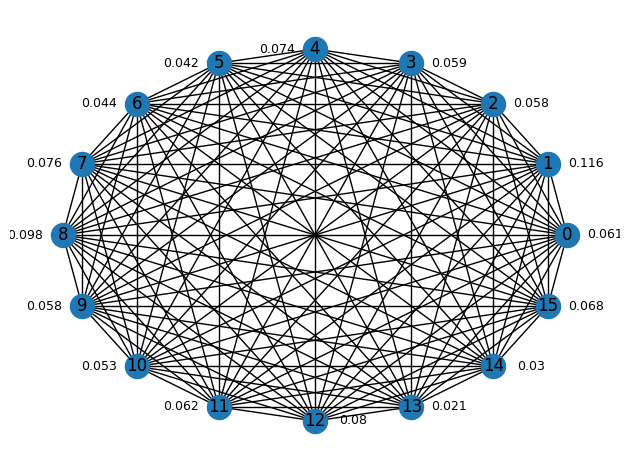

['Idina Menzel and Taye Diggs have separated after 10 years of marriage.', 'The pair has one son, Walker, 4. \n \n PHOTOS: Biggest celeb splits of 2013 \n \n "Idina Menzel and Taye Diggs have jointly decided to separate at this time," a rep for Menzel tells Us Weekly.', '"Their primary focus and concern is for their son.', 'We ask that you respect their privacy during this time." \n \n ', "PHOTOS: Hollywood's ugliest divorces \n \n The former couple, both 42, met while costarring in the original Broadway production of Rent in 1995 and later reprised their roles in the 2005 film adaptation. \n \n ", 'PHOTOS: Hollywood\'s most expensive divorces \n \n As recently as October, Diggs told Us, "We\'re doing good!"', "when congratulated on his milestone wedding anniversary at the Men's Health 25th Anniversary Party in New York City, despite the cheating rumors the couple had faced this past summer.", '||||| Taye Diggs and Idina Menzel Separate \n \n After a decade of marriage, Taye Diggs and 

In [85]:
x=summary_data_test[46]['document']
_, word_list = sentence_tokenizer(x.strip(), all=True)

g,_=graph_builder_sentence(word_list)
calculated_page_rank = _pagerank_scipy(g)
node_labels={i:round(x,3) for (i,x) in calculated_page_rank.items()}
pos = nx.circular_layout(g)
pos_higher = {}
for k, v in pos.items():
  if v[0]>0:
    pos_higher[k] = (v[0]+0.15, v[1])
  else:
    pos_higher[k] = (v[0]-0.15, v[1])
nx.draw_networkx_labels(g,pos_higher,labels=node_labels, font_size=9)
nx.draw(g, pos, with_labels=True)
plt.tight_layout()
plt.show()
y_pred = extract_sentences(x, all=True, verbose=True)
y = summary_data_test['summary'][46]